In [1]:
import json
import numpy as np

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_zho_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data_zho = json.load(f)

# Initialize a list to store the extracted values
llm_zho = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data_zho:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_zho.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_zho = np.array(llm_zho).reshape(-1, 1)
llm_zho = np.array(llm_zho).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_zho = np.where(llm_zho == "A", 0, llm_zho)
llm_zho = np.where(llm_zho == "B", 1, llm_zho)
llm_zho = np.where(llm_zho == "C", 2, llm_zho)
llm_zho = np.where(llm_zho == "D", 3, llm_zho)
llm_zho = np.where(llm_zho == "E", 4, llm_zho)
llm_zho = llm_zho.astype(int)
# convert llm_zho to numpy array
llm_zho = np.array(llm_zho)

In [2]:
import json

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_eng_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data_eng = json.load(f)

# Initialize a list to store the extracted values
llm_eng = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data_eng:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_eng.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_eng = np.array(llm_eng).reshape(-1, 1)
llm_eng = np.array(llm_eng).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_eng = np.where(llm_eng == "A", 0, llm_eng)
llm_eng = np.where(llm_eng == "B", 1, llm_eng)
llm_eng = np.where(llm_eng == "C", 2, llm_eng)
llm_eng = np.where(llm_eng == "D", 3, llm_eng)
llm_eng = np.where(llm_eng == "E", 4, llm_eng)
llm_eng = llm_eng.astype(int)
# convert llm_zho to numpy array
llm_eng = np.array(llm_eng)

In [3]:
import torch

# Prepare Data
M = 200  # Number of articles
N = 21  # Number of questions
# merge the two languages
data = np.concatenate((llm_eng, llm_zho), axis=0)

data = data[:M, :N]
# convert data to torch tensor long
answers = torch.tensor(data, dtype=torch.long)

In [4]:
# randomly select 140 articles for training, 30 articles for testing, and 30 articles for validation

np.random.seed(0)
indices = np.random.permutation(M)
train_indices = indices[:140]
val_indices = indices[140:170]
test_indices = indices[170:]
train_answers = answers[train_indices]
val_answers = answers[val_indices]
test_answers = answers[test_indices]

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])
    nll_loss = total_loss.clone()
    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss

In [6]:
def optimize_latent_vectors(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
    epochs: int = 1000,
    lr: float = 0.01,
) -> torch.Tensor:
    optimizer = optim.Adam([v], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, _ = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
    return v

In [7]:
def evaluate_model(
    model: FactorModel,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
    latent_dim: int,
    epochs: int = 1000,
    lr: float = 0.01,
) -> float:
    v = torch.randn(len(answers), latent_dim, requires_grad=True)
    v = optimize_latent_vectors(model, v, answers, lambda1, lambda2, epochs, lr)

    model.eval()
    with torch.no_grad():
        logits = model.forward(v)
        predictions = [logit.argmax(dim=1) for logit in logits]
        correct = sum(
            (pred == answers[:, n]).sum().item() for n, pred in enumerate(predictions)
        )
        accuracy = correct / (answers.size(0) * model.N)
    model.train()
    return accuracy, v

In [8]:
def train_model(
    model: FactorModel,
    train_answers: torch.Tensor,
    val_answers: torch.Tensor,
    test_answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
    eval_epochs: int = 100,
) -> Tuple[FactorModel, torch.Tensor]:

    v_train = torch.randn(len(train_answers), model.d, requires_grad=True)
    optimizer = optim.Adam(list(model.parameters()) + [v_train], lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v_train, train_answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            val_accuracy, v_val = evaluate_model(
                model, val_answers, lambda1, lambda2, model.d, eval_epochs, lr
            )
            print(
                f"Epoch {epoch}, Loss: {loss.item()}, NLL Loss: {nllloss.item()}, Val Accuracy: {val_accuracy:.4f}"
            )

    test_accuracy, v_test = evaluate_model(
        model, test_answers, lambda1, lambda2, model.d, eval_epochs, lr
    )
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    return model, v_train, v_val, v_test

In [9]:
N = 21  # Number of questions
d = 3  # Latent dimension
# list of number of categorical answers for each question
K = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5]

model = FactorModel(N, K, d)

In [10]:
epo = 2000
trained_model, v_train, v_val, v_test = train_model(
    model,
    train_answers,
    val_answers,
    test_answers,
    epochs=epo,
    lr=0.01,
    lambda1=0.01,
    lambda2=0.01,
    eval_epochs=epo,
)

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 0, Loss: 2638.875732421875, NLL Loss: 2635.18359375, Val Accuracy: 0.6095
Epoch 100, Loss: 1254.2481689453125, NLL Loss: 1248.0826416015625, Val Accuracy: 0.8841
Epoch 200, Loss: 857.4174194335938, NLL Loss: 849.03466796875, Val Accuracy: 0.9016
Epoch 300, Loss: 695.7101440429688, NLL Loss: 684.7416381835938, Val Accuracy: 0.9095
Epoch 400, Loss: 624.0342407226562, NLL Loss: 610.6656494140625, Val Accuracy: 0.9190
Epoch 500, Loss: 580.1302490234375, NLL Loss: 564.6925659179688, Val Accuracy: 0.9270
Epoch 600, Loss: 541.2942504882812, NLL Loss: 524.008056640625, Val Accuracy: 0.9333
Epoch 700, Loss: 511.7294921875, NLL Loss: 492.6186828613281, Val Accuracy: 0.9302
Epoch 800, Loss: 493.64312744140625, NLL Loss: 472.9580993652344, Val Accuracy: 0.9365
Epoch 900, Loss: 480.1446533203125, NLL Loss: 458.125732421875, Val Accuracy: 0.9365
Epoch 1000, Loss: 469.89996337890625, NLL Loss: 446.69580078125, Val Accuracy: 0.9349
Epoch 1100, Loss: 462.3193054199219, NLL Loss: 438.0296630859375

In [11]:
print(trained_model.W[0].weight)

Parameter containing:
tensor([[-1.9759,  6.6921,  0.5376]], requires_grad=True)


In [12]:
# optimize the latent vectors for all the articles
v = torch.randn(len(answers), d, requires_grad=True)
v = optimize_latent_vectors(trained_model, v, answers, 0.01, 0.01, epo, 0.01)

In [13]:
latent_vectors = v.detach().numpy()

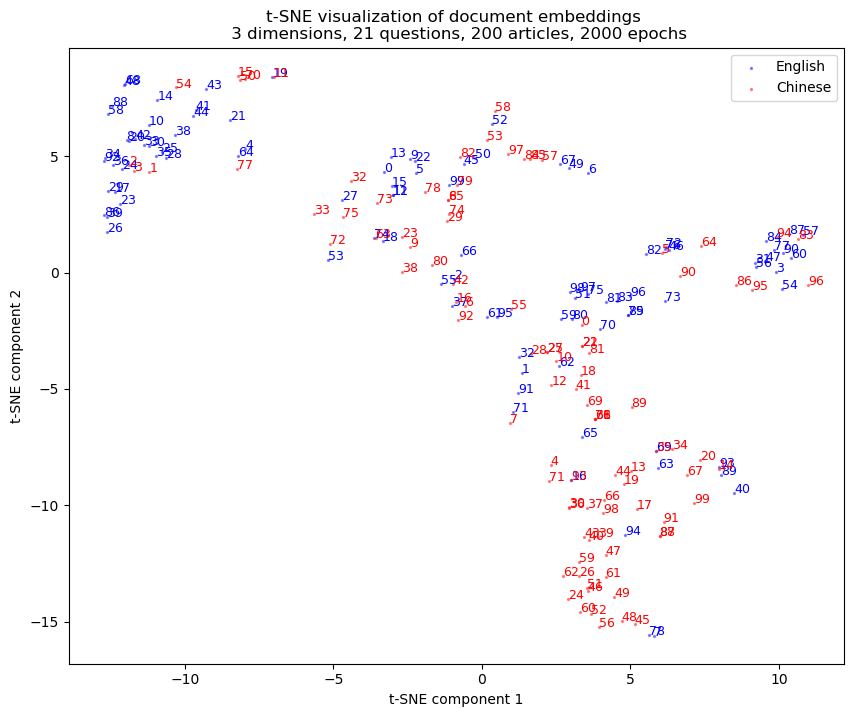

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# concatenate the latent vectors of the training, validation, and test sets
# latent_vectors = np.concatenate((latent_v_train, latent_v_val, latent_v_test), axis=0)
# reindex the latent vectors by indices
# latent_vectors = latent_vectors[np.argsort(np.concatenate((train_indices, val_indices, test_indices)))]

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
# v_2d = tsne.fit_transform(latent_vectors)
v_2d = tsne.fit_transform(latent_vectors)

# Plot the 2D embeddings with the inedx of each point
plt.figure(figsize=(10, 8))
# split the two languages
v_2d_eng = v_2d[:100]
v_2d_zho = v_2d[100:]
for index, (x, y) in enumerate(v_2d_eng):
    plt.scatter(
        x, y, alpha=0.4, color="blue", s=2, label="English" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="blue")

for index, (x, y) in enumerate(v_2d_zho):
    plt.scatter(
        x, y, alpha=0.4, color="red", s=2, label="Chinese" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="red")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend()
plt.show()

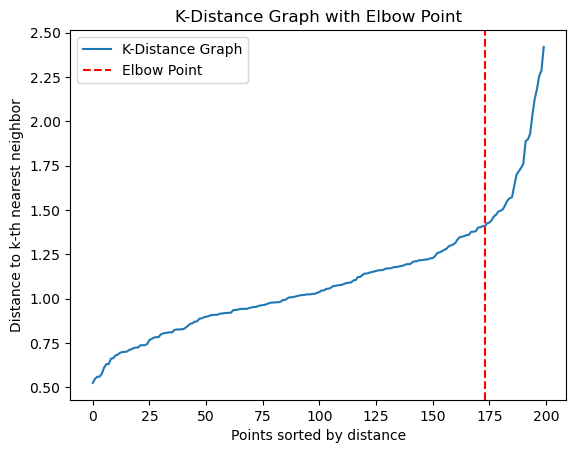

Elbow point (knee) is at index: 173, distance: 1.4088365972942132


In [15]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Compute k-nearest neighbors (k is set to min_samples)
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(v_2d)
distances, indices = nbrs.kneighbors(v_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])

x = np.arange(len(distances))
kneedle = KneeLocator(x, distances, curve="convex", direction="increasing")

# Plot the results
plt.plot(x, distances, label="K-Distance Graph")
plt.axvline(x=kneedle.knee, color="r", linestyle="--", label="Elbow Point")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to k-th nearest neighbor")
plt.title("K-Distance Graph with Elbow Point")
plt.legend()
plt.show()

# Print the knee point
print(
    f"Elbow point (knee) is at index: {kneedle.knee}, distance: {distances[kneedle.knee]}"
)

In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=distances[kneedle.knee], min_samples=min_samples)
labels = dbscan.fit_predict(v_2d)

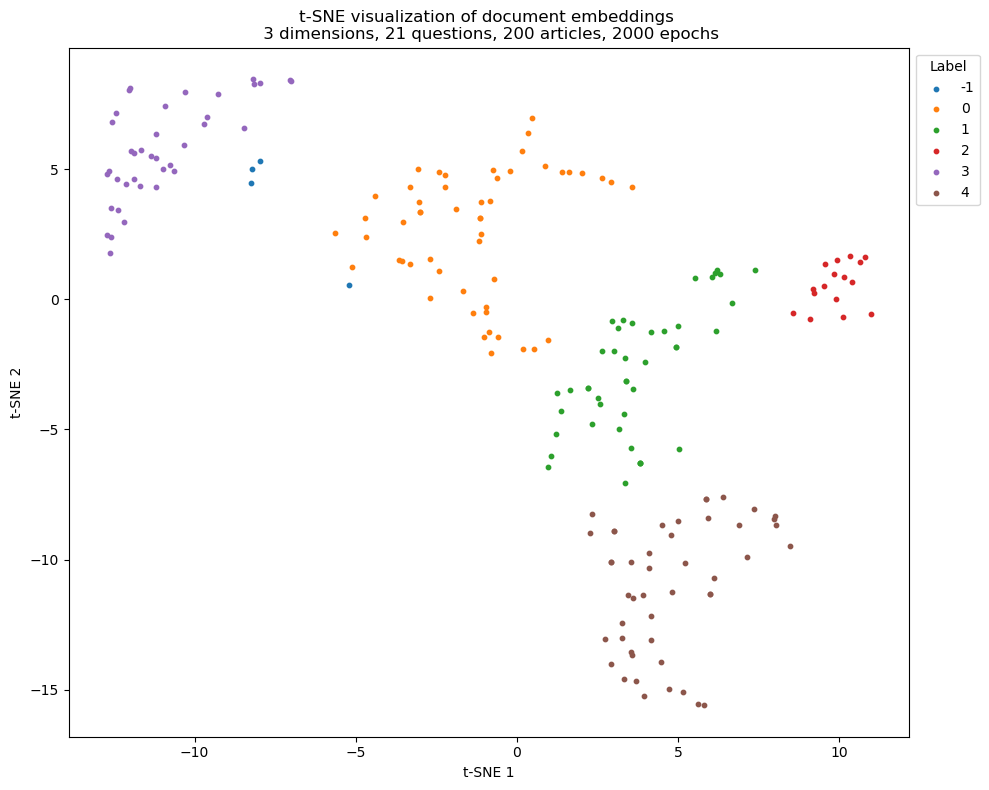

In [17]:
plt.figure(figsize=(10, 8))
for y in np.unique(labels):
    plt.scatter(
        v_2d[labels == y, 0], v_2d[labels == y, 1], label=f"{y}", s=10, marker="o"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)
plt.legend(title="Label", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [18]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.max())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Commitment to peace - Manila Standard
US Defense Secretary Lloyd Austin Confirms Restoration of US-Cambodia Ties, Joint Military Drills | CamboJA News
Malaysia urged to get tougher with Beijing over South China Sea claims
Beijing warns neighbours of US 'geopolitical self-interest' in South China Sea
China's approach to global security elaborated at Shangri-La Dialogue
Ukraine's Zelensky makes surprise stop in Manila to meet Marcos Jnr
Japan must tread carefully amid South China Sea tensions, say experts
China warns SCS patience wearing thin
Water cannons meant for saving lives  --  PCG
中国驻韩大使馆称"韩国对台湾和南中国海问题说三道四"
中國觀察：台海與南海成焦點   香格里拉對話會火藥味十足？
中国防长强调的"三个不允许"点明亚太问题的症结
中国防长董军的"香会"时刻
中方批菲总统歪曲南海事态
环球时报记者现场感受"香会"的"两面性"：既用中国"吸睛"，又为中国"设套

外交部发言人就菲律宾总统马科斯在香格里拉对话会发表涉南海问题演讲答记者问
中国驻韩使馆：敦促韩方在台湾、南海问题上谨言慎行 _中国经济网 -- -- 国家经济门户
军事专家：董军对南海、台海问题强烈关切，让美国防长亲身感受到了东方坚定的意志和坚决的立场
香格里拉對話 美中防長就台海.南海議題 交鋒不斷
中国驻韩国大使馆发言人：敦促韩方在台湾、南海问题上谨言慎行央视新闻客户端2024-6-3
中国驻韩国大使馆发言人：敦促韩方在台湾、南海问题上谨言慎行
中方香会代表团成员：我向菲海岸警卫队司令提出问题，他也表示认同
外

In [19]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.min())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

US Marines Deploy MQ-9 Reaper Drones to the Philippines - News From Antiwar.com
'The King's Speech'
Britain's MI6 recruited Chinese government employees as spies, China said. - ExBulletin
菲律賓硬起來！南海軍人持槍瞄準中國海警 小粉紅崩潰 - 國際 - 自由時報電子報


In [20]:
# get the index of cluster -1
cluster_1 = np.where(labels == 0)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

World News | Philippines Says China Coast Guard Seized Food Dropped by Plane for Filipino Forces in Disputed Sea | LatestLY
Phl, U.S., Japan coast guards vow to keep SCS safe, free
Philippines denies its troops pointed guns at Chinese coast guard personnel
Speaker says China's behavior won't improve ties
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for...
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
PBBM 'calm, not combative' in Shangri-La dialogue -- Jinggoy
Philippines denies soldiers pointed guns at China coast guard
Philippines says troops held weapons but did not point at Chinese coast guard
Analysis: China and Tr

In [21]:
# get the index of cluster -1
cluster_1 = np.where(labels == 1)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Turkey's Top Diplomat Visits China, Planning Stops in Uyghur Genocide Region
Ukrainian president berates China at Singapore security conference
Statement of Senate President Pro Tempore Jinggoy Ejercito Estrada on China Coast Guard's alleged seizure of PH supplies for BRP Sierra Madre
"Geopolitical Risk Is Everywhere"
China cites 'dishonorable role' of US in sea dispute after Marcos censure - BusinessWorld Online
China says US plays 'dishonorable role' supporting Philippines in South China Sea
Chinese defense minister denounces 'outside forces' at security forum
Cui Tiankai: External forces hyping up territorial disputes in South China Sea
Despite South China Sea row with China, Philippines eyes 'robust, stable' trade
China accuses US of escalating tension in South China Sea
World News | Finance and Equity Should Be the Core of COP29 Talks | LatestLY
Finance and equity should be the core of COP29 talks
Beijing slams 'ignoble' U.S. role in South China Sea dispute
China says US plays 'di

## Verify v that have same answers

In [22]:
v_2d[101:104], v_2d[24], v_2d[34], v_2d[36], v_2d[92]

(array([[-11.186895 ,   4.320078 ],
        [-11.868627 ,   4.6198587],
        [-11.697539 ,   4.353907 ]], dtype=float32),
 array([-12.121562 ,   4.4423656], dtype=float32),
 array([-12.668361 ,   4.9328136], dtype=float32),
 array([-12.417963 ,   4.6185794], dtype=float32),
 array([-12.7192  ,   4.810045], dtype=float32))

In [23]:
# save the v_2d to a csv file
import pandas as pd

v_2d_df = pd.DataFrame(v_2d, columns=["x", "y"])
# v_2d_df.to_csv("v_2d.csv", index=False)

In [24]:
v_2d_df

,x,y
0,-3.301260,4.317015
1,1.354450,-4.304963
2,-0.945188,-0.291897
3,9.898573,0.004300
4,-7.968656,5.315054
...,...,...
195,9.104582,-0.764813
196,10.987944,-0.553925
197,0.883817,5.113886
198,4.085070,-10.319530


In [26]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import json


v_2d_df["language"] = ["English"] * 100 + ["Chinese"] * 100

# Read the summary from JSON file
with open(
    "../CA/summary_combined_Territorial_disputes_in_the_South_China_Sea.json"
) as f:
    data = json.load(f)
summary = [item["summary"] for item in data]
v_2d_df["summary"] = summary


# Function to format summaries for hover text
def format_summary(text):
    return text.replace("\n", "<br>")


v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)

# Plot using Plotly
fig = px.scatter(
    v_2d_df,
    x="x",
    y="y",
    color="language",
    title="t-SNE Visualization of News Articles - Territorial disputes in the South China Sea",
    labels={"x": "t-SNE component 1", "y": "t-SNE component 2"},
    hover_data={"summary": False, "language": False, "x": False, "y": False},
    symbol="language",
)

# Customize the hover template to instruct user to hover
fig.update_traces(
    hovertemplate="<b>Hover over a point to see the summary</b><extra></extra>",
    customdata=v_2d_df[["formatted_summary"]].values,
)
# Update layout to adjust the width of the scatter plot
# fig.update_layout(width=1000)  # Set the width in pixels

# Save the plot as an HTML file with embedded JavaScript and CSS
html_content = f"""
<html>
<head>
    <title>Interactive Plot</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        #summary-box {{
            position: absolute;
            top: 10px;
            right: 10px;
            width: 30vw;
            max-height: 98vh;
            overflow-y: auto;
            background-color: white;
            border: 1px solid black;
            padding: 10px;
            z-index: 1000;
            white-space: pre-line;
        }}
    </style>
</head>
<body>
    <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
    <div id="summary-box">Hover over a point to see the summary here.</div>
    <script>
        document.addEventListener('DOMContentLoaded', function() {{
            const plotDiv = document.getElementById('plot');
            const plotElement = plotDiv.querySelector('.js-plotly-plot');
            const newWidth = window.innerWidth * 2 / 3;
            Plotly.relayout(plotElement, 'width', newWidth);
            plotElement.on('plotly_hover', function(data) {{
                if(data.points.length > 0) {{
                    const summary = data.points[0].customdata[0];
                    document.getElementById('summary-box').innerHTML = summary;
                }}
            }});
            plotElement.on('plotly_unhover', function(data) {{
                document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
            }});
            
        }});
    </script>
</body>
</html>
"""

# Save the HTML content to a file
with open("interactive_plot_train_eva_test.html", "w") as f:
    f.write(html_content)